## Baseline
This notebook implments a baseline model, which shows you how to handle the data and to provide a first very simple solution to the problem. You may re-use and modify any part of this notebook.

In [ ]:
!pip install torchmetrics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 14.4 MB/s eta 0:00:00


In [ ]:
import os
import csv
import torch
import pickle
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm.notebook import tqdm
from google.colab import drive
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from torchmetrics import AUROC, F1Score

In [ ]:
drive = drive.mount('/content/drive')
data_dir = 'drive/MyDrive/kaggle_data'

Mounted at /content/drive


In [ ]:
torch.manual_seed(0)

### Exploratory Data Analysis(EDA)

In [ ]:
# Change the path to your Google Drive folder
data_dir = 'drive/MyDrive/Deep Learning Toxic Comment/kaggle_data'

# Load dataset
train_x = pd.read_csv(os.path.join(data_dir, 'train_x.csv'))
train_y = pd.read_csv(os.path.join(data_dir, 'train_y.csv'))
val_x = pd.read_csv(os.path.join(data_dir, 'val_x.csv'))
val_y = pd.read_csv(os.path.join(data_dir, 'val_y.csv'))
test_x = pd.read_csv(os.path.join(data_dir, 'test_x.csv'))

# Display basic information about the dataset
print("Train X info:")
print(train_x.info())
print("\nTrain Y info:")
print(train_y.info())
print("\nValidation X info:")
print(val_x.info())
print("\nValidation Y info:")
print(val_y.info())
print("\nTest X info:")
print(test_x.info())

# Print the first few lines and check the data structure
print("\nTrain X head:")
print(train_x.head())
print("\nTrain Y head:")
print(train_y.head())
print("\nValidation X head:")
print(val_x.head())
print("\nValidation Y head:")
print(val_y.head())
print("\nTest X head:")
print(test_x.head())

Train X info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269038 entries, 0 to 269037
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   index   269038 non-null  int64 
 1   string  269037 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.1+ MB
None

Train Y info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269038 entries, 0 to 269037
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype
---  ------              --------------   -----
 0   male                269038 non-null  int64
 1   female              269038 non-null  int64
 2   LGBTQ               269038 non-null  int64
 3   christian           269038 non-null  int64
 4   muslim              269038 non-null  int64
 5   other_religions     269038 non-null  int64
 6   black               269038 non-null  int64
 7   white               269038 non-null  int64
 8   identity_any        269038 non-null  int64
 9   severe_toxicit

# Data cleaning and distribution analysis

In [ ]:
# Data Cleaning: Dealing with Missing Values
print("\nChecking missing values...")
print("Train X missing values:\n", train_x.isnull().sum())
print("Train Y missing values:\n", train_y.isnull().sum())
print("Validation X missing values:\n", val_x.isnull().sum())
print("Validation Y missing values:\n", val_y.isnull().sum())
print("Test X missing values:\n", test_x.isnull().sum())

# Delete rows in Train X with missing values
train_x = train_x.dropna().reset_index(drop=True)
train_y = train_y.iloc[train_x.index].reset_index(drop=True)

#Fill missing values ​​in Test X
test_x = test_x.fillna('')  # pad with empty string

# Unified string format
train_x['string'] = train_x['string'].str.lower()
val_x['string'] = val_x['string'].str.lower()
test_x['string'] = test_x['string'].str.lower()

# Check whether the value ranges of target variables and features are as expected
print("\nTarget variable distribution in Train Y:")
print(train_y['y'].value_counts())

# Examine the distribution of each toxicity profile
toxic_features = ['severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']
print("\nToxicity features distribution in Train Y:")
print(train_y[toxic_features].sum(axis=0))

# Make sure there are no missing values ​​in the validation set and test set
assert val_x.isnull().sum().sum() == 0, "Validation X still has missing values!"
assert test_x.isnull().sum().sum() == 0, "Test X still has missing values!"


Checking missing values...
Train X missing values:
 index     0
string    1
dtype: int64
Train Y missing values:
 male                  0
female                0
LGBTQ                 0
christian             0
muslim                0
other_religions       0
black                 0
white                 0
identity_any          0
severe_toxicity       0
obscene               0
threat                0
insult                0
identity_attack       0
sexual_explicit       0
y                     0
from_source_domain    0
dtype: int64
Validation X missing values:
 index     0
string    0
dtype: int64
Validation Y missing values:
 male                  0
female                0
LGBTQ                 0
christian             0
muslim                0
other_religions       0
black                 0
white                 0
identity_any          0
severe_toxicity       0
obscene               0
threat                0
insult                0
identity_attack       0
sexual_explicit       0
y      

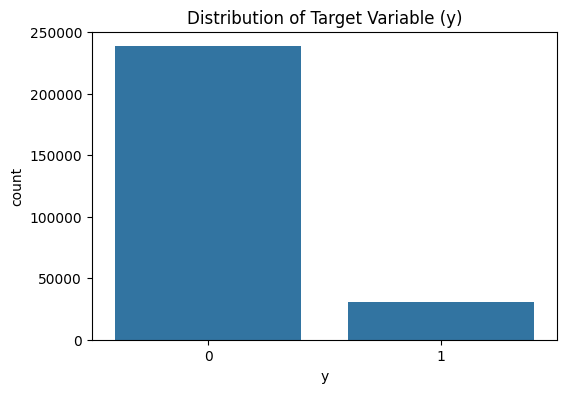

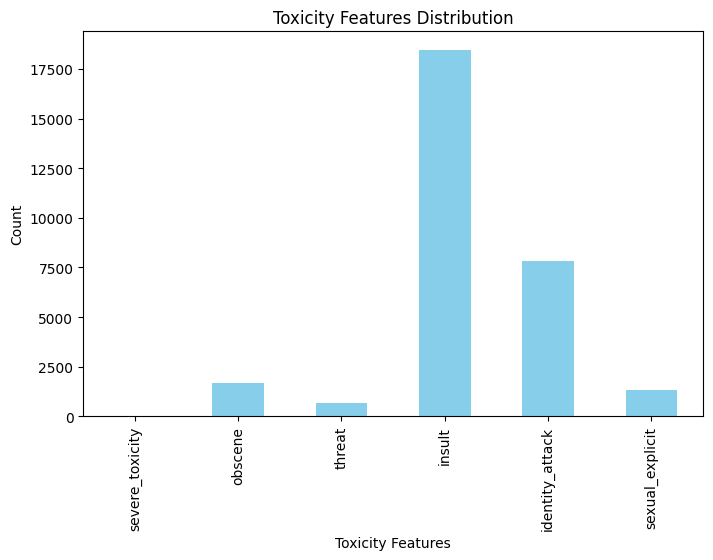

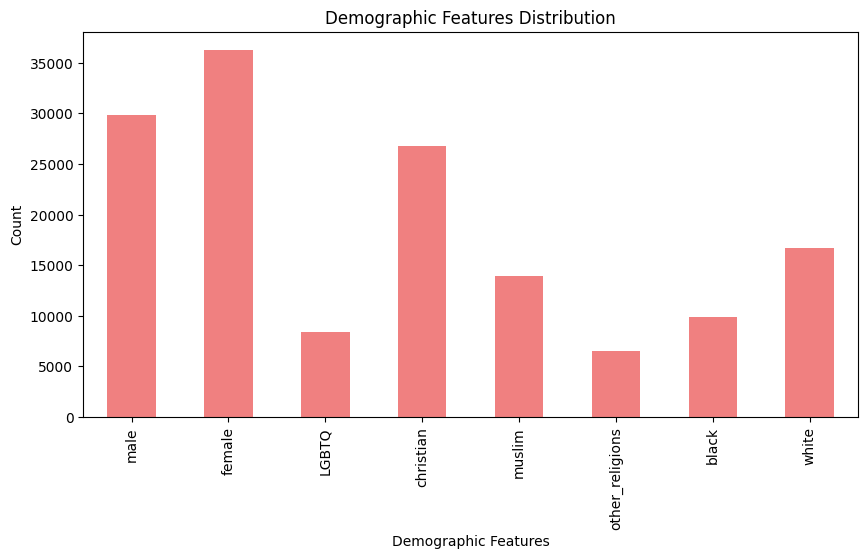

In [ ]:
# Analyze target variable distribution
import matplotlib.pyplot as plt
import seaborn as sns

# Plot target variable distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='y', data=train_y)
plt.title('Distribution of Target Variable (y)')
plt.show()

# Analyzing the distribution of toxicity profiles
toxic_sums = train_y[toxic_features].sum(axis=0)
toxic_sums.plot(kind='bar', figsize=(8, 5), color='skyblue')
plt.title('Toxicity Features Distribution')
plt.ylabel('Count')
plt.xlabel('Toxicity Features')
plt.show()

# Analyze the distribution of demographic characteristics
demographic_features = ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']
demo_sums = train_y[demographic_features].sum(axis=0)
demo_sums.plot(kind='bar', figsize=(10, 5), color='lightcoral')
plt.title('Demographic Features Distribution')
plt.ylabel('Count')
plt.xlabel('Demographic Features')
plt.show()

# Text length and toxicity analysis

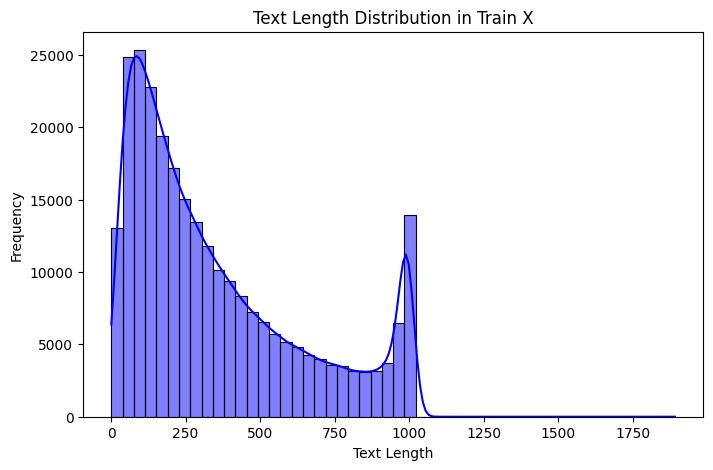


Text Length Category Counts:
text_length_category
medium    145888
long       69634
short      53515
Name: count, dtype: int64

Conditional Probabilities P(y=1 | toxic feature=1):
severe_toxicity: 1.00
obscene: 0.98
threat: 0.98
insult: 0.98
identity_attack: 0.93
sexual_explicit: 0.85


In [ ]:
# Text length distribution analysis
train_x['text_length'] = train_x['string'].apply(len)
val_x['text_length'] = val_x['string'].apply(len)
test_x['text_length'] = test_x['string'].apply(len)

# Plot the distribution of text lengths
plt.figure(figsize=(8, 5))
sns.histplot(train_x['text_length'], bins=50, color='blue', kde=True)
plt.title('Text Length Distribution in Train X')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# Sort by text length
short_threshold = 100
long_threshold = 500

train_x['text_length_category'] = train_x['text_length'].apply(
    lambda x: 'short' if x < short_threshold else ('long' if x > long_threshold else 'medium')
)

# Distribution of the number of texts in each category
text_length_counts = train_x['text_length_category'].value_counts()
print("\nText Length Category Counts:")
print(text_length_counts)

# Relationship between toxicity characteristics and target variables
toxic_probabilities = {}
for feature in toxic_features:
    count_y_and_feature = len(train_y[(train_y['y'] == 1) & (train_y[feature] == 1)])
    count_feature = len(train_y[train_y[feature] == 1])
    probability = count_y_and_feature / count_feature if count_feature > 0 else 0
    toxic_probabilities[feature] = probability

print("\nConditional Probabilities P(y=1 | toxic feature=1):")
for feature, prob in toxic_probabilities.items():
    print(f"{feature}: {prob:.2f}")

# Generate word cloud visualization

Generating WordClouds...


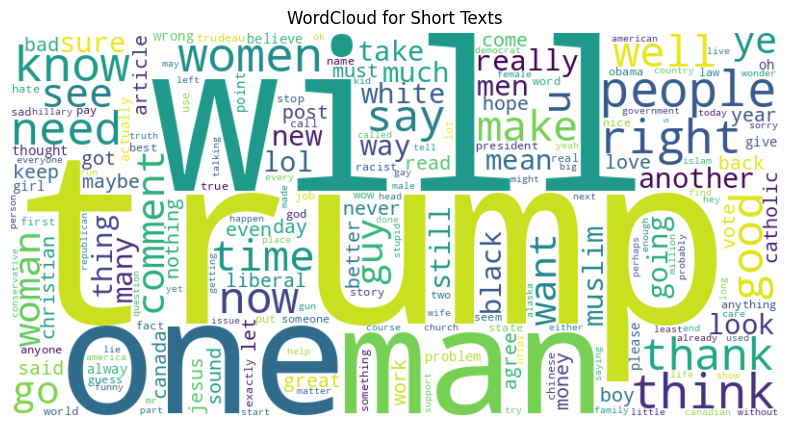

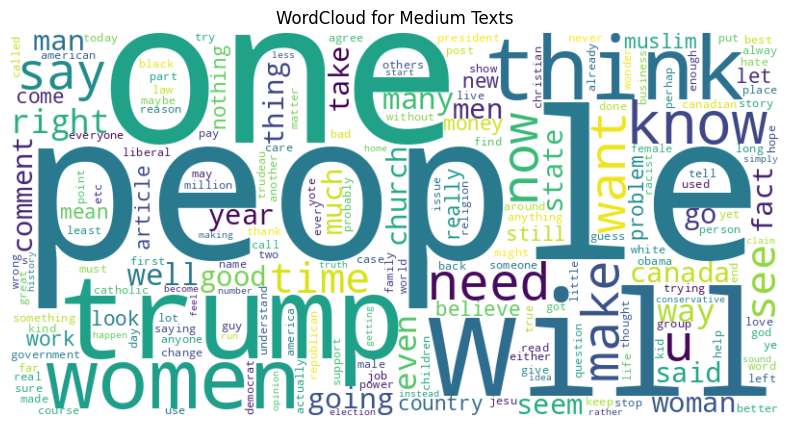

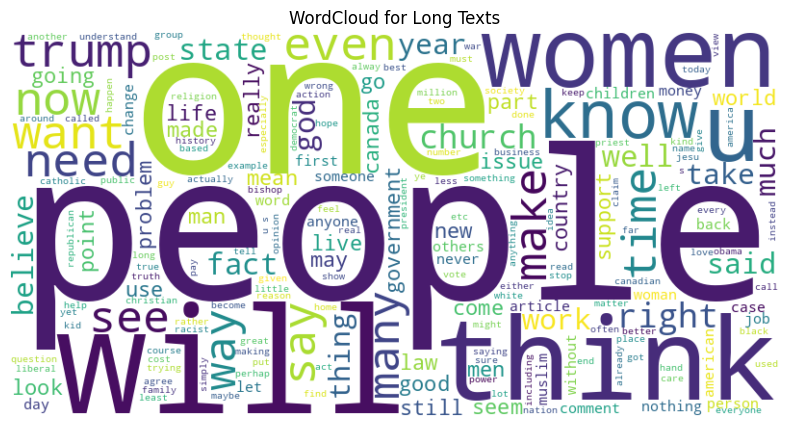

In [ ]:
from wordcloud import WordCloud

# Define functions to generate word clouds
def generate_wordcloud(data, title):
    text = ' '.join(data['string'].values)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Generate word clouds of different text lengths
print("Generating WordClouds...")
generate_wordcloud(train_x[train_x['text_length_category'] == 'short'], "WordCloud for Short Texts")
generate_wordcloud(train_x[train_x['text_length_category'] == 'medium'], "WordCloud for Medium Texts")
generate_wordcloud(train_x[train_x['text_length_category'] == 'long'], "WordCloud for Long Texts")

# Relationship between demographic characteristics and target variables

<ipython-input-12-5543916c6626>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=demographic_features, y=correlations, palette='viridis')


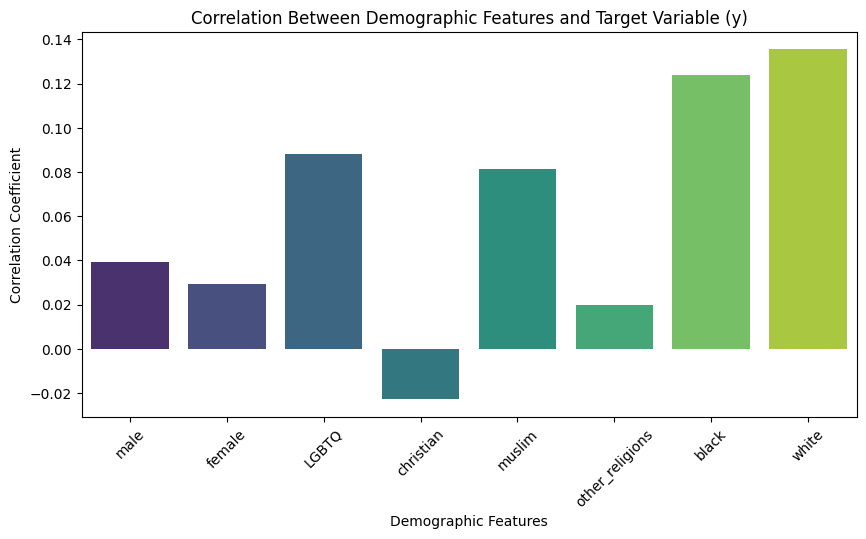

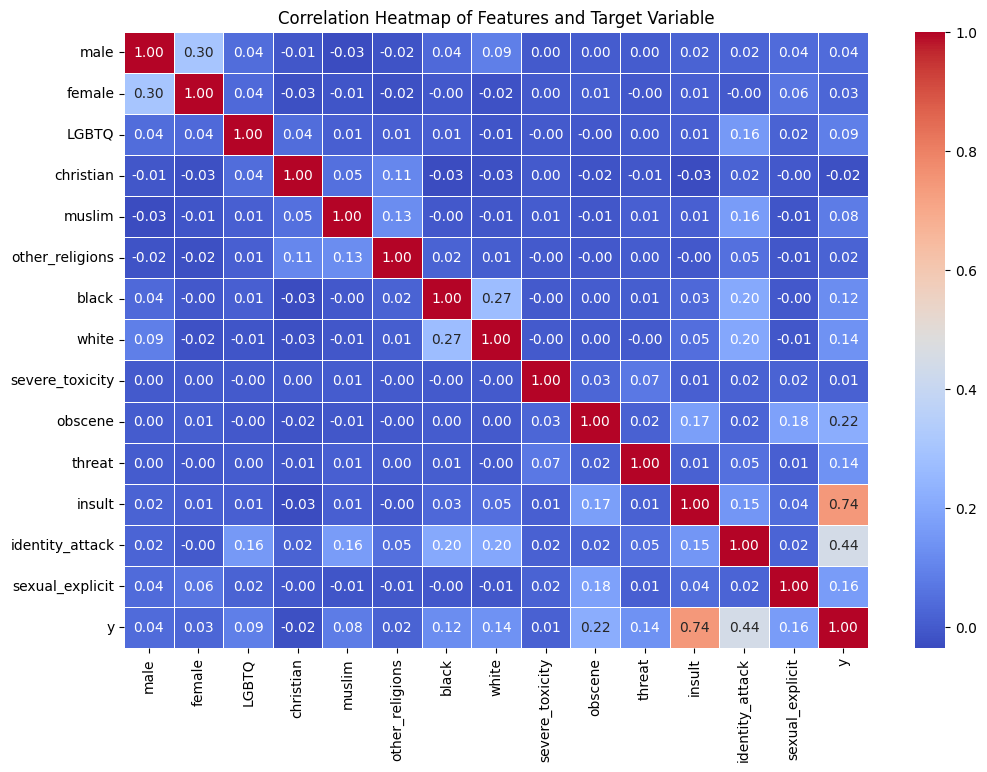

In [ ]:
# The impact of demographic characteristics on target variables
demographic_features = ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']
correlations = []

for feature in demographic_features:
    corr = train_y[['y', feature]].corr().iloc[0, 1]
    correlations.append(corr)

# Draw a correlation histogram
plt.figure(figsize=(10, 5))
sns.barplot(x=demographic_features, y=correlations, palette='viridis')
plt.title('Correlation Between Demographic Features and Target Variable (y)')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Demographic Features')
plt.xticks(rotation=45)
plt.show()

# Generate correlation heatmap
correlation_matrix = train_y[demographic_features + toxic_features + ['y']].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Features and Target Variable')
plt.show()